In [20]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

import gc
import torch

In [2]:
BATCH_SIZE = 1
C = 3 # number of channels of the input image
H = 640 # heigh of the input image
W = 640 # width of the input image

# mAP CARACTERIZATION

# Base model

In [4]:
model = YOLO('weights/yolov11salmons.pt', task='segment')
metrics = model.val(data='datasets/salmons/salmons.yaml', task='segment', verbose=False,conf=0.4,device='cuda')
print('base model box mAP50: ', metrics.box.map50)
print('base model box mAP50-95: ', metrics.box.map)

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.3.0 CUDA:0 (Orin, 62841MiB)
YOLOv8l-seg summary (fused): 313 layers, 41,738,835 parameters, 0 gradients, 200.5 GFLOPs


val: Scanning /home/juam/Documents/SalmonsTRT/datasets/salmons/labels/val.cache... 52 images, 34 backgrounds, 0 corrupt: 100%|██████████| 86/86 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


                   all         86        496      0.674      0.567      0.628      0.451      0.669      0.562      0.646      0.387
Speed: 0.8ms preprocess, 63.2ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to /home/juam/Documents/SalmonsTRT/runs/segment/val5
base model box mAP50:  0.6282889555249598
base model box mAP50-95:  0.4508632871603391


# TRT fp32

In [3]:
model = YOLO('weights/yolov11salmons_fp32_bs128_640.engine', task='segment')
metrics = model.val(data='datasets/salmons/salmons.yaml', task='segment', verbose=False,conf=0.4,device='cuda')
print('base model box mAP50: ', metrics.box.map50)
print('base model box mAP50-95: ', metrics.box.map)

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.3.0 CUDA:0 (Orin, 62841MiB)
Loading weights/yolov11salmons_fp32_bs128_640.engine for TensorRT inference...
[01/02/2025-12:46:08] [TRT] [I] Loaded engine size: 163 MiB
[01/02/2025-12:46:08] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +159, now: CPU 0, GPU 159 (MiB)
[01/02/2025-12:46:12] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +1, GPU +11800, now: CPU 1, GPU 11959 (MiB)


val: Scanning /home/juam/Documents/SalmonsTRT/datasets/salmons/labels/val.cache... 52 images, 34 backgrounds, 0 corrupt: 100%|██████████| 86/86 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.18s/it]


                   all         86        496      0.669      0.562      0.625      0.453      0.701       0.56      0.653      0.389
Speed: 2.4ms preprocess, 60.2ms inference, 0.0ms loss, 9.3ms postprocess per image
Results saved to /home/juam/Documents/SalmonsTRT/runs/segment/val6
base model box mAP50:  0.625205670162876
base model box mAP50-95:  0.4530417665131125


# TRT fp16

In [4]:
model = YOLO('weights/yolov11salmons_fp16_bs128_640.engine', task='segment')
metrics = model.val(data='datasets/salmons/salmons.yaml', task='segment', verbose=False,conf=0.4,device='cuda')
print('base model box mAP50: ', metrics.box.map50)
print('base model box mAP50-95: ', metrics.box.map)

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.3.0 CUDA:0 (Orin, 62841MiB)
Loading weights/yolov11salmons_fp16_bs128_640.engine for TensorRT inference...
[01/02/2025-12:46:48] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[01/02/2025-12:46:49] [TRT] [I] Loaded engine size: 83 MiB
[01/02/2025-12:46:49] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +80, now: CPU 1, GPU 12039 (MiB)
[01/02/2025-12:46:51] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +1, GPU +6100, now: CPU 2, GPU 18139 (MiB)


val: Scanning /home/juam/Documents/SalmonsTRT/datasets/salmons/labels/val.cache... 52 images, 34 backgrounds, 0 corrupt: 100%|██████████| 86/86 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]


                   all         86        496      0.672      0.562       0.63      0.452      0.707      0.568      0.654      0.391
Speed: 2.1ms preprocess, 29.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /home/juam/Documents/SalmonsTRT/runs/segment/val7
base model box mAP50:  0.6304362547006185
base model box mAP50-95:  0.45231202420519584


# TRT int8

In [5]:
model = YOLO('weights/yolov11salmons_int8_bs128_640.engine', task='segment')
metrics = model.val(data='datasets/salmons/salmons.yaml', task='segment', verbose=False,conf=0.4,device='cuda')
print('base model box mAP50: ', metrics.box.map50)
print('base model box mAP50-95: ', metrics.box.map)

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.3.0 CUDA:0 (Orin, 62841MiB)
Loading weights/yolov11salmons_int8_bs128_640.engine for TensorRT inference...
[01/02/2025-12:47:21] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[01/02/2025-12:47:21] [TRT] [I] Loaded engine size: 45 MiB
[01/02/2025-12:47:21] [TRT] [W] Using an engine plan file across different models of devices is not recommended and is likely to affect performance or even cause errors.
[01/02/2025-12:47:21] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +40, now: CPU 1, GPU 6220 (MiB)
[01/02/2025-12:47:22] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +1, GPU +3617, now: CPU 2, GPU 9837 (MiB)


val: Scanning /home/juam/Documents/SalmonsTRT/datasets/salmons/labels/val.cache... 52 images, 34 backgrounds, 0 corrupt: 100%|██████████| 86/86 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


                   all         86        496      0.745      0.429      0.595      0.424      0.762       0.44      0.612       0.37
Speed: 0.7ms preprocess, 18.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /home/juam/Documents/SalmonsTRT/runs/segment/val8
base model box mAP50:  0.5947989196339593
base model box mAP50-95:  0.4244624839610732


# PIXEL TO PIXEL CARACTERIZATION

## Compare output segmentations masks

In [63]:
base_model = YOLO('weights/yolov11salmons.pt', task='segment')
results_base = base_model.predict("datasets/salmons/images/val/Img3.jpeg",show_boxes=False,save=True, conf=0.4)


image 1/1 /home/juam/Documents/SalmonsTRT/datasets/salmons/images/val/Img3.jpeg: 384x640 34 salmons, 98.9ms
Speed: 3.7ms preprocess, 98.9ms inference, 7.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /home/juam/Documents/SalmonsTRT/runs/segment/predict5


In [65]:
trt_model =  YOLO('weights/yolov11salmons_fp16_bs128_640.engine', task='segment')
results_trt = trt_model.predict("datasets/salmons/images/val/Img3.jpeg", show_boxes=False,save=True, conf=0.4)

Loading weights/yolov11salmons_fp16_bs128_640.engine for TensorRT inference...
[01/02/2025-16:58:53] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[01/02/2025-16:58:53] [TRT] [I] Loaded engine size: 83 MiB
[01/02/2025-16:58:53] [TRT] [W] Using an engine plan file across different models of devices is not recommended and is likely to affect performance or even cause errors.


[01/02/2025-16:58:53] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +80, now: CPU 2, GPU 7395 (MiB)
[01/02/2025-16:58:54] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +1, GPU +6100, now: CPU 3, GPU 13495 (MiB)

image 1/1 /home/juam/Documents/SalmonsTRT/datasets/salmons/images/val/Img3.jpeg: 384x640 34 salmons, 26.6ms
Speed: 3.1ms preprocess, 26.6ms inference, 6.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /home/juam/Documents/SalmonsTRT/runs/segment/predict7


In [93]:
def compare_images(image1, image2):
    # Leer imágenes
    img1 = cv2.imread(image1)  # Groundtruth
    img2 = cv2.imread(image2)  # Modelo predicho

    if img1.shape != img2.shape:
        raise ValueError("Las imágenes deben tener el mismo tamaño y número de canales")

    # Convertir imágenes a HSV
    hsv_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    hsv_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)

    # Crear máscara de la segmentación del groundtruth (azul)
    lower_blue = np.array([100, 100, 50])
    upper_blue = np.array([140, 255, 255])
    groundtruth_mask = cv2.inRange(hsv_img1, lower_blue, upper_blue)

    # Aplicar máscara al modelo predicho y al groundtruth
    gt_segment = cv2.bitwise_and(img1, img1, mask=groundtruth_mask)
    pred_segment = cv2.bitwise_and(img2, img2, mask=groundtruth_mask)

    # Usar el canal azul en lugar de convertir a escala de grises
    blue_gt = gt_segment[:, :, 0]
    blue_pred = pred_segment[:, :, 0]

    # Calcular píxeles iguales dentro de la máscara del groundtruth
    equal_pixels = np.sum((blue_gt == blue_pred) & (groundtruth_mask > 0))
    total_pixels_in_mask = np.sum(groundtruth_mask > 0)

    # Calcular el closeness dentro de la máscara
    closeness_percentage = (equal_pixels / total_pixels_in_mask) * 100 if total_pixels_in_mask > 0 else 0

    # Crear una visualización de diferencias
    overlay = np.zeros_like(img1, dtype=np.uint8)
    overlay[:, :, 2] = 255  # Canal rojo para resaltar diferencias

    diferencia = cv2.absdiff(blue_gt, blue_pred)
    _, diferencia_binaria = cv2.threshold(diferencia, 10, 255, cv2.THRESH_BINARY)
    mask_differences = cv2.bitwise_and(overlay, overlay, mask=diferencia_binaria)

    # Ajustar la mezcla para mantener el brillo original
    img1_with_differences = cv2.addWeighted(img1, 1, mask_differences, 1, 0.0)

    return img1_with_differences, closeness_percentage

closeness:  60.93818500657606 %


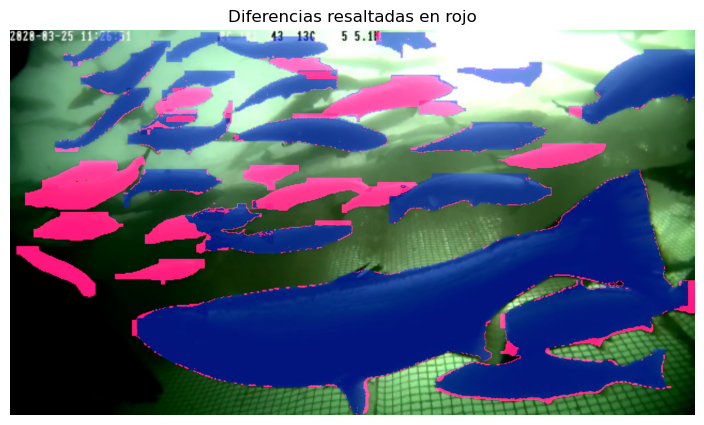

In [94]:
comparacion_binaria, closeness = compare_images('outputs/segmentation/vanilla.jpg','outputs/segmentation/int8.jpg')
cv2.imwrite('outputs/segmentation/salmon_binario.jpg', comparacion_binaria)

# Mostrar la imagen con matplotlib
print("closeness: ", closeness, '%')
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(comparacion_binaria, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB para mostrar correctamente con matplotlib
plt.axis('off')  # Ocultar ejes
plt.title("Diferencias resaltadas en rojo")
plt.show()

In [17]:
# Eliminar objetos
del base_model
del trt_model
gc.collect()
# Limpiar caché de la GPU
torch.cuda.empty_cache()